In [1]:
print('chat am i cooked ?')

chat am i cooked ?


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from scipy.optimize import minimize

In [3]:
# Seed generator from alphabetic string
def seed_gen(string):
    num_str = [ord(letter) - 96 for letter in string]
    # seed must be between 0 and 2**32 - 1
    return(np.mod(int(''.join(map(str,num_str))),2**32 - 1))

seeds = ['matterlab', 'alba', 'jakob', 'alan']

s = 0 # default seed, used in the main article results
np.random.seed(seed_gen(seeds[s])) 

In [4]:
num_qubits = 4
dev = qml.device("default.qubit", wires=num_qubits)

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Ground state energy')

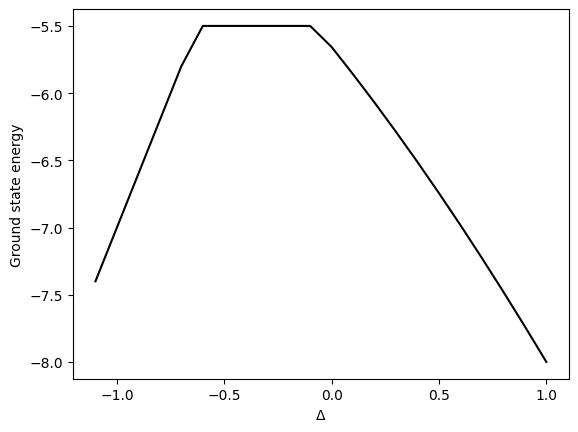

In [5]:
def spin_ham_XXZ(n, lam, delta):
    coeff = []
    operators = []

    # periodic boundary conditions (just so that it wraps around)
    operators.append(qml.PauliX(n-1) @ qml.PauliX(0))
    coeff.append(1.0)
    operators.append(qml.PauliY(n-1) @ qml.PauliY(0))
    coeff.append(1.0)
    operators.append(qml.PauliZ(n-1) @ qml.PauliZ(0))
    coeff.append(delta)

    for i in range(n-1):
        # XX coupling
        operators.append(qml.PauliX(i) @ qml.PauliX(i+1))
        coeff.append(1.0)

        # YY coupling
        operators.append(qml.PauliY(i) @ qml.PauliY(i+1))
        coeff.append(1.0)
        
        # ZZ coupling
        operators.append(qml.PauliZ(i) @ qml.PauliZ(i+1))
        coeff.append(delta)

    #transverse field
    for i in range(n):
        operators.append(qml.PauliZ(i))
        coeff.append(lam)
    return qml.Hamiltonian(coeff, operators)

# Function to compute the ground state energy
def ground_state(n, lam, delta):
    H = spin_ham_XXZ(n, lam, delta)
    H_matrix = qml.matrix(H, wire_order=list(range(n)))
    eigvals = np.linalg.eigvals(H_matrix)
    return min(eigvals)


exac = []
delta = np.arange(-1.1, 1.1, 0.1)
lam = 0.75
for d in delta:
    E0 = ground_state(n=num_qubits, delta=d, lam=lam)
    exac.append(E0)
plt.plot(delta, exac, label='Exact', color='black')
plt.xlabel('Δ')
plt.ylabel('Ground state energy')


In [6]:
# function to generate single qubit rotation gates
def single_rot(phi,theta, target):
    qml.RZ(phi, wires=target) 
    qml.RY(theta, wires=target)

In [7]:
# Function to generate encoding and processing layers
def processing_layer(proc_params, target, n, num_layers):
    for i in range(num_layers):
        p = i % 2  #even/odd check
        for j in range(n):
            phi, theta = proc_params[i][j]
            single_rot(phi, theta, target[j])
        for j in range(p, n-1, 2):
            qml.CNOT(wires=[target[j], target[j+1]])

def encoding_layer(enc_params, w_params, delta, target, n, num_layers):
    for i in range(num_layers):
        p = i % 2
        for j in range(n):
            phi, theta = enc_params[i][j]
            wth, wph = w_params[i][j]
            single_rot(wth * delta + phi, wph * delta + theta, target[j])
        for j in range(p, n - 1, 2):
            qml.CNOT(wires=[target[j], target[j + 1]])


<class 'numpy.ndarray'>
(<Figure size 1500x500 with 1 Axes>, <Axes: >)


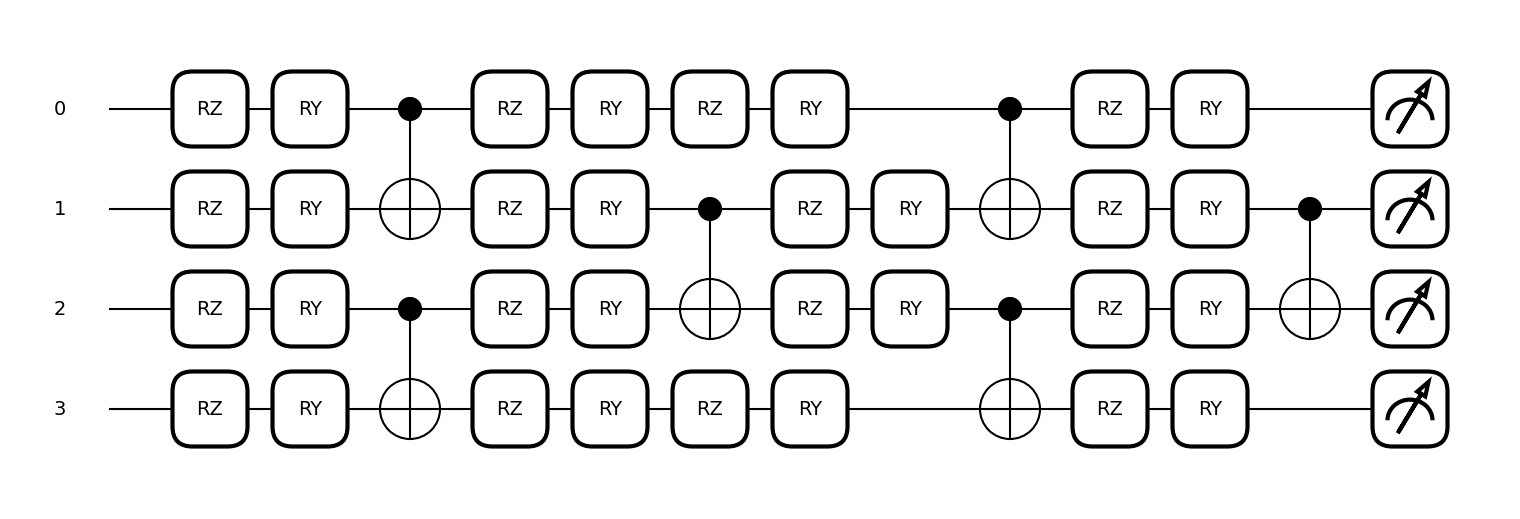

In [8]:
# Function to check if the ansatz circuit matches the one in the paper
@qml.qnode(dev)
def circuit(proc_params, enc_params, w_params, n, lam, delta, num_layers):
    ham = spin_ham_XXZ(n, lam, delta)
    # encoding layer
    encoding_layer(enc_params, w_params, delta, range(n), n, num_layers)
    # processing layer
    processing_layer(proc_params, range(n), n, num_layers)

    return qml.expval(ham)


num_layers = 2

w_params = np.random.uniform(0, np.pi, (num_layers, num_qubits, 2)) 
proc_params = np.random.uniform(0, np.pi, (num_layers, num_qubits, 2))
enc_params = np.random.uniform(0, np.pi, (num_layers, num_qubits, 2))


print(type(proc_params))
drawer = qml.draw_mpl(circuit)
print(drawer(proc_params, enc_params, w_params, num_qubits, lam, 0.8, num_layers)) 


<class 'numpy.ndarray'>
0.3943783137166745


Text(0.5, 1.0, 'Expectation value of Hamiltonian vs Delta')

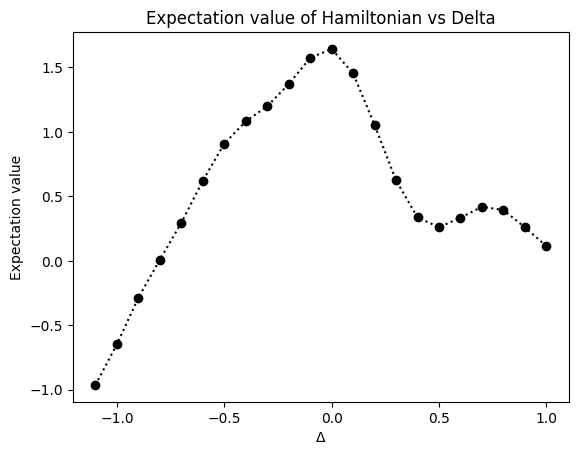

In [9]:
@qml.qnode(dev)
def expectation_value(proc_params,enc_params, w_params, n, lam, delta):
    
    ham = spin_ham_XXZ(n, lam, delta)
    # encoding layer
    encoding_layer(enc_params,w_params, delta, range(n), n, 2)
    # processing layer
    processing_layer(proc_params, range(n), n, 1)
    return qml.expval(ham)

# little check on the type of the output
exp_value = expectation_value(proc_params, enc_params, w_params, n=num_qubits, lam=lam, delta=0.8)
print(type(exp_value))
print(exp_value)

# compute the expectation value for different delta values in the range [-1.1, 1.1] defined above
exp_vals = []
for d in delta:
    exp_val = expectation_value(proc_params, enc_params, w_params, n=num_qubits, lam=lam, delta=d)
    exp_vals.append(exp_val)

   

plt.plot(delta, exp_vals, marker='o', linestyle=':', color='black')
plt.xlabel('Δ')
plt.ylabel('Expectation value')
plt.title('Expectation value of Hamiltonian vs Delta')

In [10]:
# generate circuit
@qml.qnode(dev, diff_method="best")
def meta_vqe_circuit(proc_params, enc_params, w_params, n, lam, delta, num_layers):
    # encoding layer
    encoding_layer(enc_params,w_params, delta, range(n), n, num_layers)
    # processing layer
    processing_layer(proc_params, range(n), n, 1)

    ham = spin_ham_XXZ(n, lam, delta)
    return qml.expval(ham)


def loss_function(proc_params, enc_params, w_params, n, lam, deltas):
    loss = 0
    for delta in deltas:
        loss += meta_vqe_circuit(proc_params, enc_params, w_params, n, lam, delta, num_layers)
    return loss/len(deltas)

In [11]:
# Generating the training set 
n_train = 20
n_test = 100

delta_min = 1.1
delta_max = -1.1
deltas_train = [delta_min + (delta_max - delta_min) * i / (n_train - 1) for i in range(n_train)]
lam = 0.75

#number of layers for each type of layer
enc_n_layers = 2
proc_n_layers = 1

init_proc_params = np.random.uniform(0, np.pi, (proc_n_layers, num_qubits, 2))
init_enc_params = np.random.uniform(0, np.pi, (enc_n_layers, num_qubits, 2))
init_w_params = np.random.uniform(0, np.pi, (enc_n_layers, num_qubits, 2))


### Meta-VQE with BFGS optimizer

In [12]:
proc_params = np.random.uniform(0, np.pi, (proc_n_layers,num_qubits, 2))
w_params = np.random.uniform(0, np.pi, (enc_n_layers,num_qubits, 2))
enc_params = np.random.uniform(0, np.pi, (enc_n_layers,num_qubits, 2))

In [13]:
# generate circuit
@qml.qnode(dev, diff_method="finite-diff")
def meta_vqe_circuit(proc_params, enc_params, w_params, n, lam, delta, num_layers):
    # encoding layer
    encoding_layer(enc_params, w_params, delta, range(n), n, num_layers)
    # processing layer
    processing_layer(proc_params, range(n), n, proc_n_layers)

    ham = spin_ham_XXZ(n, lam, delta)
    return qml.expval(ham)


In [14]:
# we need to flatten the parameters to be able to use the minimize function
flat_params = np.concatenate([proc_params.flatten(), enc_params.flatten(), w_params.flatten()])

# Define shapes for reshaping later
proc_shape = proc_params.shape
enc_shape = enc_params.shape
w_shape = w_params.shape

proc_size = np.prod(proc_shape)
enc_size = np.prod(enc_shape)

losses = []

# Define the cost function
def cost_fn(flat_params):
    # Reshape flat_params back to original shapes
    
    proc_params_reshaped = flat_params[:proc_size].reshape(proc_shape)
    enc_params_reshaped = flat_params[proc_size:proc_size + enc_size].reshape(enc_shape)
    w_params_reshaped = flat_params[proc_size + enc_size:].reshape(w_shape)
    
    # Compute the loss
    loss = loss_function(proc_params_reshaped, enc_params_reshaped,
                          w_params_reshaped, num_qubits, lam, deltas_train)
    losses.append(loss)
    return loss


result = minimize(cost_fn, flat_params, method='BFGS', jac= '2-point',
                   options={"maxiter": 100})

# Extract optimized parameters
optimized_flat_params = result.x
trained_proc_params = optimized_flat_params[:proc_size].reshape(proc_shape)
trained_enc_params = optimized_flat_params[proc_size:proc_size + enc_size].reshape(enc_shape)
trained_w_params = optimized_flat_params[proc_size + enc_size:].reshape(w_shape)

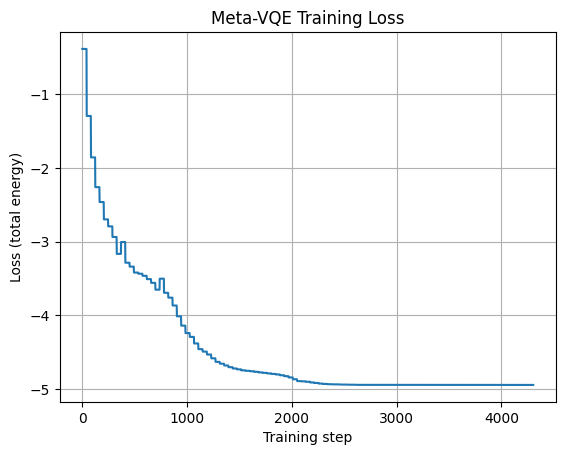

In [15]:
plt.plot(losses)
plt.xlabel("Training step")
plt.ylabel("Loss (total energy)")
plt.title("Meta-VQE Training Loss")
plt.grid()
plt.show()

In [16]:
delta_sample = 0.8

before = meta_vqe_circuit(proc_params, enc_params, w_params, num_qubits, lam, delta_sample, num_layers)
after  = meta_vqe_circuit(trained_proc_params, trained_enc_params, 
                          trained_w_params, num_qubits, lam, delta_sample, num_layers)

print("Before training:", before)
print("After training:", after)

Before training: -0.34384172794657597
After training: -5.254807591560629


In [17]:
x_train = deltas_train 
y_train_ex = []
y_train_metaVQE = []
error_train_metaVQE = []

# Loop over all training points
for delta in deltas_train:
    # Use trained parameters to evaluate the circuit
    pred_energy = meta_vqe_circuit(trained_proc_params, trained_enc_params,
                                    trained_w_params, num_qubits, lam, delta, num_layers)

    # Reference exact solution 
    true_energy = ground_state(num_qubits, lam, delta)

    # print(delta, true_energy, pred_energy, abs(pred_energy-true_energy))
    # Store results
    y_train_metaVQE.append(pred_energy)
    y_train_ex.append(true_energy)
    error_train_metaVQE.append(abs(pred_energy - true_energy))
    print(delta, true_energy, pred_energy, abs(pred_energy-true_energy))


1.1 (-8.269596362197392+0j) -6.070734644631092 2.1988617175662997
0.9842105263157895 (-7.957968735090017+0j) -5.536388725149325 2.4215800099406914
0.868421052631579 (-7.654326410152783-2.5788741912857425e-32j) -5.2265525465315195 2.4277738636212636
0.7526315789473685 (-7.358964309688821-5.258244272280804e-32j) -5.314290072351152 2.0446742373376683
0.6368421052631579 (-7.0721556874022795+1.1967515713430746e-32j) -5.325035155034859 1.7471205323674202
0.5210526315789474 (-6.794146933686838-1.906013951685095e-51j) -4.928170362439275 1.8659765712475629
0.4052631578947369 (-6.525152542288214+0j) -4.352524587705041 2.172627954583173
0.2894736842105263 (-6.265350454327089+0j) -4.039788200756672 2.2255622535704163
0.17368421052631577 (-6.014877999336955+0j) -4.109415972383155 1.9054620269538
0.05789473684210522 (-5.773828639527448+0j) -4.269803119533915 1.504025519993533
-0.05789473684210522 (-5.542249692159046+0j) -4.183963522127198 1.3582861700318478
-0.17368421052631589 (-5.500000000000004+0

In [18]:
deltas_test = [np.random.uniform(delta_min, delta_max) for _ in range(n_test)]
deltas_test.sort()

x_test = deltas_test
y_test_ex = []
y_test_metaVQE = []
error_test_metaVQE = []

# Inference on test points
for delta in x_test:
    pred_energy = meta_vqe_circuit(trained_proc_params, trained_enc_params, 
                                   trained_w_params, num_qubits, lam, delta, num_layers)
    exact_energy = ground_state(num_qubits, lam, delta) 

    y_test_metaVQE.append(pred_energy)
    y_test_ex.append(exact_energy)
    error_test_metaVQE.append(abs(pred_energy - exact_energy))
    # print(delta, exact_energy, pred_energy, abs(pred_energy - exact_energy))


/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


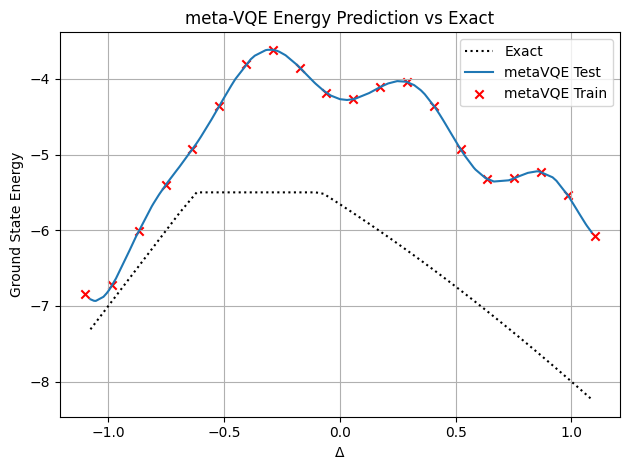

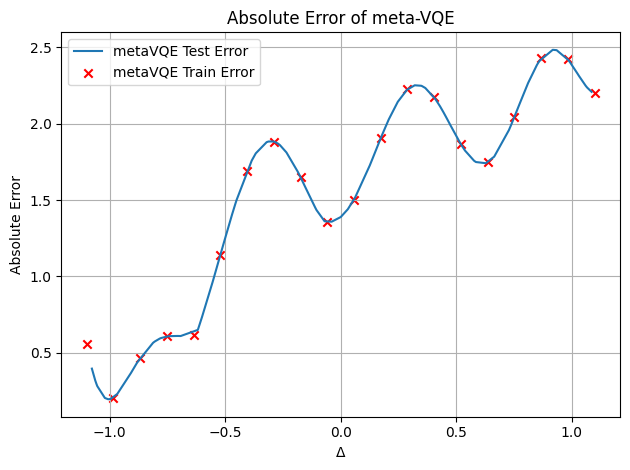

In [19]:
# Ground state energy plot
plt.plot(x_test, y_test_ex, color="black", linestyle=":", label="Exact")
plt.plot(x_test, y_test_metaVQE, linestyle="-", label="metaVQE Test")
plt.scatter(x_train, y_train_metaVQE, color="red", marker="x", label="metaVQE Train")
plt.xlabel(r"$\Delta$")
plt.ylabel("Ground State Energy")
plt.title("meta-VQE Energy Prediction vs Exact")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Absolute error plot
plt.plot(x_test, error_test_metaVQE, linestyle="-", label="metaVQE Test Error")
plt.scatter(x_train, error_train_metaVQE, color="red", marker="x", label="metaVQE Train Error")
plt.xlabel(r"$\Delta$")
plt.ylabel("Absolute Error")
plt.title("Absolute Error of meta-VQE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Standard VQE

In [20]:
# the main difference between VQE and meta-VQE is that all layers are equivalent to processing layers
@qml.qnode(dev, diff_method="finite-diff")
def vqe_circuit(proc_params, n, lam, delta):
    processing_layer(proc_params, range(n), n, enc_n_layers+proc_n_layers)
    ham = spin_ham_XXZ(n, lam, delta)
    return qml.expval(ham)

In [21]:
losses = []
y_VQE = []
error_yVQE = []

# Define the cost function for each delta value
def cost_fn(params, delta):
    params_reshaped = params.reshape(vqe_proc_shape)
    return vqe_circuit(params_reshaped, num_qubits, lam, delta)

for i in range(n_train):
    delta = deltas_train[i]

    proc_params = np.random.uniform(0, np.pi, (proc_n_layers+ enc_n_layers,num_qubits, 2))
    vqe_proc_shape = proc_params.shape
    vqe_flat_params = proc_params.flatten()
    
    vqe_proc_size = np.prod(vqe_proc_shape)
    
    # Create a closure for this specific delta
    objective = lambda p: cost_fn(p, delta)
    
    # Optimize
    result = minimize(objective, vqe_flat_params, method='BFGS', 
                     jac='2-point', options={"maxiter": 100})
    
    # Store results
    loss = cost_fn(result.x, delta)
    losses.append(loss)
    y_VQE.append(loss)
    error_yVQE.append(abs(loss - y_train_ex[i]))
    
    print(deltas_train[i], y_train_ex[i], loss, abs(loss - y_train_ex[i]))

1.1 (-8.269596362197392+0j) -6.530363222759876 1.7392331394375162
0.9842105263157895 (-7.957968735090017+0j) -6.354538163619509 1.6034305714705077
0.868421052631579 (-7.654326410152783-2.5788741912857425e-32j) -6.194106984448974 1.4602194257038095
0.7526315789473685 (-7.358964309688821-5.258244272280804e-32j) -6.04538908390955 1.313575225779271
0.6368421052631579 (-7.0721556874022795+1.1967515713430746e-32j) -5.677814958125799 1.3943407292764807
0.5210526315789474 (-6.794146933686838-1.906013951685095e-51j) -5.779857601604705 1.0142893320821322
0.4052631578947369 (-6.525152542288214+0j) -5.660509874819803 0.8646426674684111
0.2894736842105263 (-6.265350454327089+0j) -5.548580219001834 0.7167702353252547
0.17368421052631577 (-6.014877999336955+0j) -5.443374497253643 0.5715035020833117
0.05789473684210522 (-5.773828639527448+0j) -5.344500461220832 0.4293281783066156
-0.05789473684210522 (-5.542249692159046+0j) -5.25186856124059 0.29038113091845563
-0.17368421052631589 (-5.500000000000004

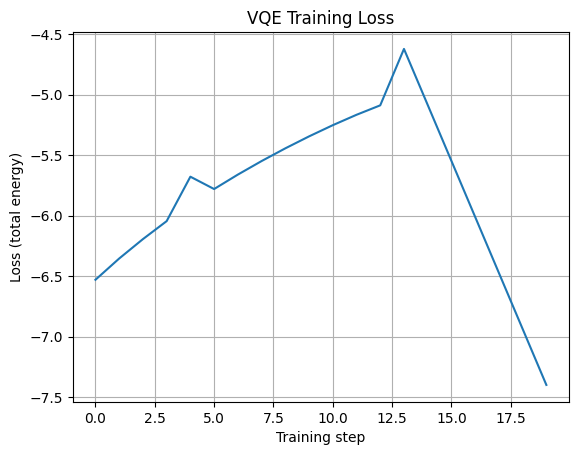

In [22]:
plt.plot(losses)
plt.xlabel("Training step")
plt.ylabel("Loss (total energy)")
plt.title("VQE Training Loss")
plt.grid()
plt.show()

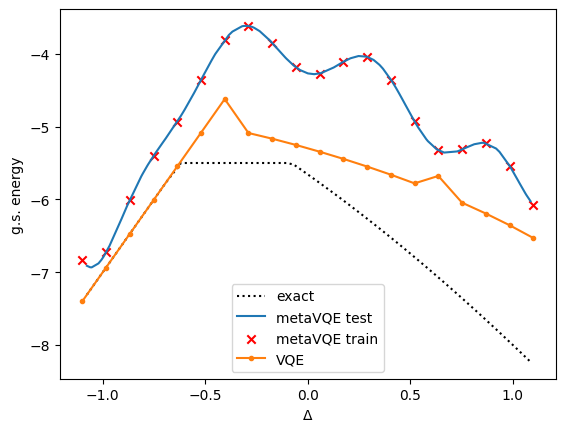

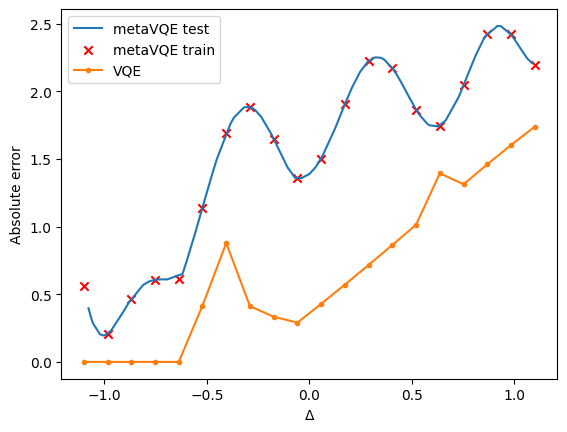

In [23]:
plt.plot(x_test, y_test_ex, color="black", ls=":", label="exact")
plt.plot(x_test, y_test_metaVQE,  ls="-", label="metaVQE test")
plt.scatter(x_train, y_train_metaVQE, color="red", marker="x", label="metaVQE train")
plt.plot(x_train, y_VQE,  marker=".", label="VQE")
plt.xlabel("Δ")
plt.ylabel('g.s. energy')
plt.legend()
plt.show()


plt.plot(x_test, error_test_metaVQE, ls="-", label="metaVQE test")
plt.scatter(x_train, error_train_metaVQE, marker="x", color="red", label="metaVQE train")
plt.plot(x_train, error_yVQE, marker=".", label="VQE")
plt.xlabel("Δ")
plt.ylabel("Absolute error")
plt.legend()
plt.show()



### OPT-meta-VQE

In [24]:
@qml.qnode(dev, diff_method="best")
def opt_meta_vqe_circuit(proc_params, enc_params, w_params, n, lam, delta, num_layers):
    # encoding layer
    encoding_layer(enc_params,w_params, delta, range(n), n, num_layers)
    # processing layer
    processing_layer(proc_params, range(n), n, 1)

    ham = spin_ham_XXZ(n, lam, delta)
    return qml.expval(ham)

In [25]:
# Initialize the parameters
opt_proc_params = trained_proc_params.copy()
opt_enc_params = trained_enc_params.copy()
opt_w_params = trained_w_params.copy()

In [26]:
opt_flat_params = np.concatenate([opt_proc_params.flatten(), opt_enc_params.flatten(), opt_w_params.flatten()])

# Define shapes for reshaping later
proc_shape = opt_proc_params.shape
enc_shape = opt_enc_params.shape
w_shape = opt_w_params.shape

proc_size = np.prod(proc_shape)
enc_size = np.prod(enc_shape)

In [27]:
y_opt_metaVQE = []
error_y_opt_metaVQE = []

# Define the cost function
def opt_cost_fn(flat_params, delta):
    # Reshape flat_params back to original shapes
    
    proc_params_reshaped = flat_params[:proc_size].reshape(proc_shape)
    enc_params_reshaped = flat_params[proc_size:proc_size + enc_size].reshape(enc_shape)
    w_params_reshaped = flat_params[proc_size + enc_size:].reshape(w_shape)
    
    return opt_meta_vqe_circuit(proc_params_reshaped, enc_params_reshaped, 
                                w_params_reshaped, num_qubits, lam, delta, num_layers)

for i in range(n_train):
    delta = deltas_train[i]
    
    # Create a closure for this specific delta
    opt_objective = lambda opt_flat_params: opt_cost_fn(opt_flat_params, delta)
    
    # Optimize
    opt_result = minimize(opt_objective, opt_flat_params, method='BFGS', 
                     jac='2-point', options={"maxiter": 100, "finite_diff_rel_step": 1e-4})
    
    # Store results
    opt_loss = opt_cost_fn(opt_result.x, delta)
    y_opt_metaVQE.append(opt_loss)
    error_y_opt_metaVQE.append(abs(opt_loss - y_train_ex[i]))
    
    print(deltas_train[i], y_train_ex[i], opt_loss, abs(opt_loss - y_train_ex[i]))


1.1 (-8.269596362197392+0j) -6.218181663424172 2.05141469877322
0.9842105263157895 (-7.957968735090017+0j) -6.354537768814027 1.6034309662759894
0.868421052631579 (-7.654326410152783-2.5788741912857425e-32j) -6.1941059758004755 1.4602204343523075
0.7526315789473685 (-7.358964309688821-5.258244272280804e-32j) -6.04538830142762 1.313576008261201
0.6368421052631579 (-7.0721556874022795+1.1967515713430746e-32j) -5.907690282028602 1.1644654053736776
0.5210526315789474 (-6.794146933686838-1.906013951685095e-51j) -5.779857438406504 1.0142894952803339
0.4052631578947369 (-6.525152542288214+0j) -5.660508288542046 0.8646442537461674
0.2894736842105263 (-6.265350454327089+0j) -5.54857937518673 0.7167710791403588
0.17368421052631577 (-6.014877999336955+0j) -5.443374000457495 0.5715039988794599
0.05789473684210522 (-5.773828639527448+0j) -5.344500234771406 0.42932840475604195
-0.05789473684210522 (-5.542249692159046+0j) -5.251864529477262 0.29038516268178327
-0.17368421052631589 (-5.500000000000004

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


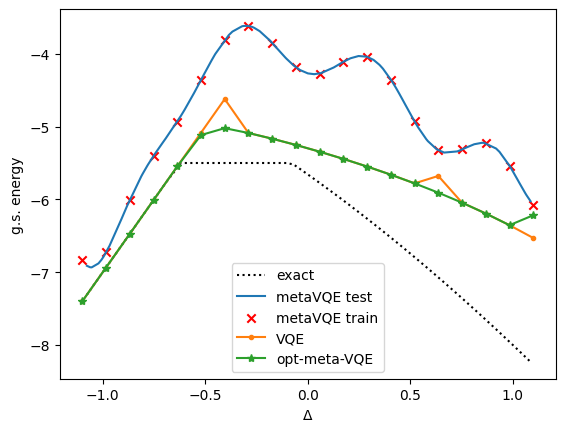

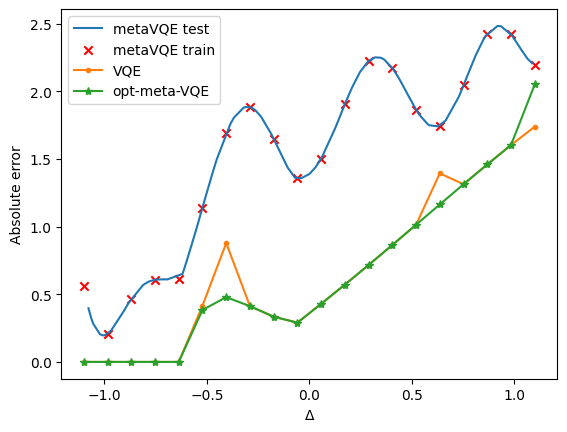

In [28]:
plt.plot(x_test, y_test_ex, color="black", ls=":", label="exact")
plt.plot(x_test, y_test_metaVQE,  ls="-", label="metaVQE test")
plt.scatter(x_train, y_train_metaVQE, color="red", marker="x", label="metaVQE train")
plt.plot(x_train, y_VQE,  marker=".", label="VQE")
plt.plot(x_train, y_opt_metaVQE, marker="*", label="opt-meta-VQE")


plt.xlabel("Δ")
plt.ylabel('g.s. energy')
plt.legend()

plt.show()

# Absolute error

plt.plot(x_test, error_test_metaVQE, ls="-", label="metaVQE test")
plt.scatter(x_train, error_train_metaVQE, marker="x", color="red", label="metaVQE train")
plt.plot(x_train, error_yVQE, marker=".", label="VQE")
plt.plot(x_train, error_y_opt_metaVQE, marker="*", label="opt-meta-VQE")


plt.xlabel("Δ")
plt.ylabel("Absolute error")
plt.legend()
plt.show()

